<a href="https://colab.research.google.com/github/imenebak/VisDrone_CC/blob/master/TrainVal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17698124213978123568, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8266430907402002008
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2678956099628912732
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5713989210494193941
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/Neerajj9/CSRNet-keras.git

Cloning into 'CSRNet-keras'...
remote: Enumerating objects: 195, done.
remote: Total 195 (delta 0), reused 0 (delta 0), pack-reused 195
Receiving objects: 100% (195/195), 169.46 MiB | 37.95 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
!unzip "/content/drive/My Drive/VisdroneCrowdCounting/train_test_Visdrone2020_simple_density.zip"

**pretrained model**

In [ ]:
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import numpy as np
import random
import math
import sys

In [ ]:
K.clear_session()

In [ ]:
logging = TensorBoard(log_dir=log_dir)

In [ ]:
root = '/content/'

In [ ]:
train = os.path.join(root,'train','sequences')
test = os.path.join(root,'test','sequences')
path_sets = [train, test]

In [ ]:
path_sets

In [ ]:
img_paths_test = []
for img_path in glob.glob(os.path.join(path_sets[1], '*.jpg')):
        img_paths_test.append(str(img_path))
print("Test image importation .. Total images : ",len(img_paths_test))
test_sum = len(img_paths_test)

Test image importation .. Total images :  210


In [ ]:
img_paths_train = []
for img_path in glob.glob(os.path.join(path_sets[0], '*.jpg')):
        img_paths_train.append(str(img_path))
print("Train image importation .. Total images : ",len(img_paths_train))
train_sum = len(img_paths_train)

Train image importation .. Total images :  420


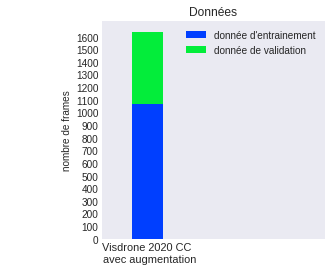

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
plt.style.use("seaborn-bright")
plt.figure(figsize=(4,4))
N = 2
SMALL_SIZE = 11
menMeans = (1066,0)
womenMeans = (574,0)
ind = np.arange(N)    # the x locations for the groups
width = 0.2      # the width of the bars: can also be len(x) sequence
p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans)
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.ylabel('nombre de frames')
plt.title("Données")
es = "                               "
plt.xticks(ind-0.3, (es+'Visdrone 2020 CC \n'+es+' avec augmentation', ''))
plt.yticks(np.arange(0, 1066+574, 100))
#plt.legend(loc="upper left")
plt.legend(["donnée d'entrainement", "donnée de validation"], loc='upper right')

plt.show()

In [ ]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    """width, height = im.size 
    newsize = (width // 2, height //2)
    im = im.resize(newsize)"""
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    #print(path)
    path = path[0] 
    img = create_img(path)
    return(img)

def get_output(path):
    #import target
    #resize target
    #print(path)
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]//8),int(target.shape[0]//8)),interpolation = cv2.INTER_CUBIC)*64
    
    img = np.expand_dims(img,axis  = 2)
    
    #print(img.shape)
    
    return img

def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    #imm = np.resize(image,((image.shape[0]//2),int(image.shape[1]//2)))
    #tar = np.resize(target,((image.shape[0]//2),int(image.shape[1]//2)))
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)

In [ ]:
#Image data generator 
def image_generator(files, batch_size = 64):
    #print("hi")
    while True:        
        input_path = np.random.choice(a = files, size = batch_size)
        #print(input_path)
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path)
        output = get_output(input_path[0].replace('.jpg','.h5').replace('sequences','ground_truth') )
        
        #print(inputt,output)
       
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        #batch_xx, batch_yy = preprocess_input(batch_x, batch_y)
        #batch_x = np.append(batch_x, batch_xx)
        #batch_y = np.append(batch_y, batch_yy)
        yield( batch_x, batch_y )

In [ ]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [ ]:
def init_weights_vgg(model):
    #vgg =  VGG16(weights='imagenet', include_top=False)
    
    json_file = open('/content/CSRNet-keras/models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/CSRNet-keras/weights/VGG_16.h5")
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    offset=0
    i=0
    while(i<10): #10
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)

In [ ]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [ ]:
def mae(y_true, y_pred):
    return abs(K.sum(y_true) - K.sum(y_pred))
    #return mean_absolute_error(np.array(K.sum(y_true)),np.array(K.sum(y_pred)))
def mse(y_true, y_pred):
    #return tf.math.sqrt((K.sum(y_true) - K.sum(y_pred)) * (K.sum(y_true) - K.sum(y_pred)))
    #tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.math.sqrt(K.sum(y_true) * K.sum(y_pred))
    #return tf.math.sqrt(K.sum(y_true) - K.sum(y_pred))
    

In [ ]:
K.clear_session()
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            
            #Batch Normalisation option
            
            batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel,  input_shape = (rows,cols,3),activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))#64
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))#128
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            #Conv2D
            model.add(Dropout(0.3))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = "same"))
            model.add(Dropout(0.3))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Dropout(0.1))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Dropout(0.1))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
            #model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
            #tf.keras.losses.Huber()
            model.compile(optimizer=Adam(1e-5), loss='accuracy', metrics=[mae, "mse"])
            #optimizer=Adam(1e-5)
            model = init_weights_vgg(model)
            
            return model

In [ ]:
!rm -r log

In [ ]:
model = CrowdNet()

In [ ]:
#poursuivre trainig
#model = load_model()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
log_dir = './log/'

In [ ]:
model.summary()

In [ ]:
#print(model.get_weights())

In [ ]:
checkpoint = ModelCheckpoint(log_dir + "best_weights.h5", verbose=1, monitor='val_mae',save_freq='epoch', save_weights_only=True, save_best_only=True, mode='auto')

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.2, patience=4, verbose=1)

In [ ]:
from keras.callbacks import EarlyStopping
stopit = EarlyStopping(monitor="val_mae",patience=30)

In [ ]:
callbacks = [checkpoint,logging, reduce_lr]#, stopit

In [ ]:
batch = 1 #28

In [ ]:
train_gen = image_generator(img_paths_train,batch)

In [ ]:
val_gen = image_generator(img_paths_test,batch)

In [ ]:
sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
#model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
#tf.keras.losses.CosineSimilarity(axis=1) =loss
model.compile(optimizer=Adam(1e-5), loss='mae', metrics=[mae, "mse", 'accuracy'])

In [ ]:
NUM_EPOCHS = 50

In [ ]:
history = model.fit(train_gen,
	steps_per_epoch=train_sum // batch,
	validation_data=val_gen,
	validation_steps=test_sum // batch,
	epochs=NUM_EPOCHS,
  verbose = 1,
  callbacks=callbacks
	)

In [ ]:
print(history.history)

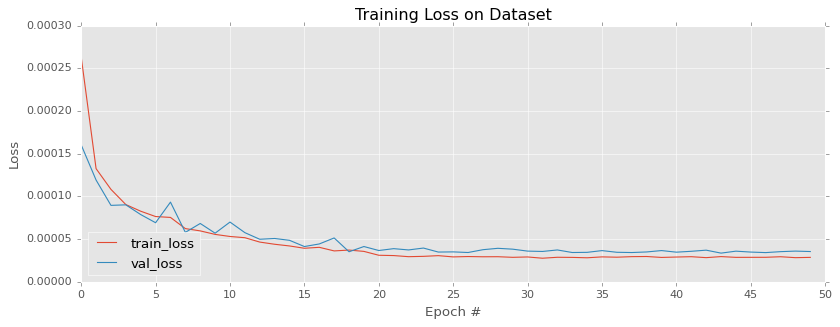

In [ ]:
N = NUM_EPOCHS
H=history
plt.style.use("classic")
plt.style.use("ggplot")
plt.figure(figsize = (12,4))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.xticks(np.arange(0,N+2,5))

plt.legend(loc="lower left")
plt.savefig("plotLoss.png")

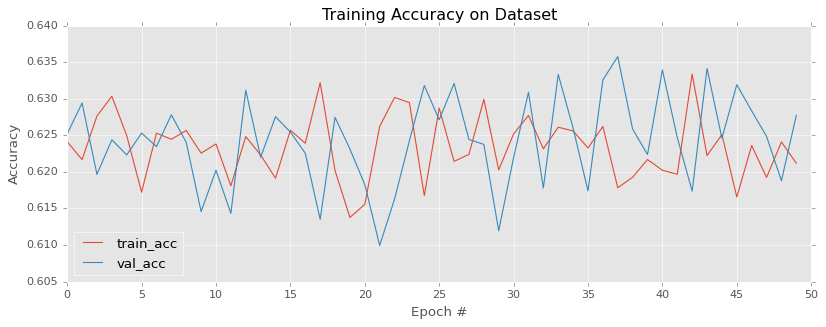

In [ ]:
N = NUM_EPOCHS
H=history
plt.style.use("ggplot")
plt.figure(figsize = (12,4))

plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0,N+2,5))
#plt.yticks(np.arange(0,1,0.1))
axes = plt.gca()
#axes.xaxis.set_ticklabels(np.arange(0, N), rotation = 0, color = 'black', fontsize = 12,  verticalalignment = 'bottom')
plt.legend(loc="lower left")
plt.savefig("plotAccuracy .png")

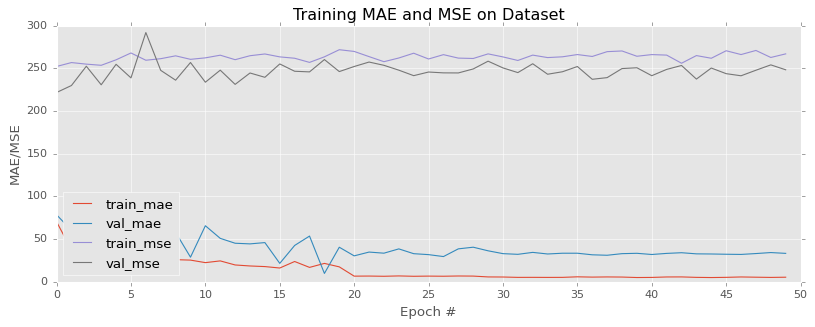

In [ ]:
N = NUM_EPOCHS
H=history
plt.style.use("ggplot")
plt.figure(figsize = (12,4))
plt.plot(np.arange(0, N), H.history["mae"], label="train_mae")
plt.plot(np.arange(0, N), H.history["val_mae"], label="val_mae")
plt.plot(np.arange(0, N), H.history["mse"], label="train_mse")
plt.plot(np.arange(0, N), H.history["val_mse"], label="val_mse")
plt.title("Training MAE and MSE on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("MAE/MSE")
plt.xticks(np.arange(0,N+2,5))
plt.legend(loc="lower left")
plt.savefig("plotMAEMSE.png")

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_mae', 'val_mse', 'val_accuracy', 'loss', 'mae', 'mse', 'accuracy', 'lr'])


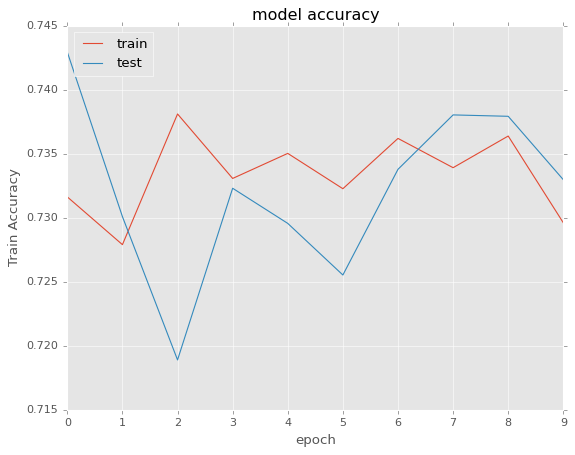

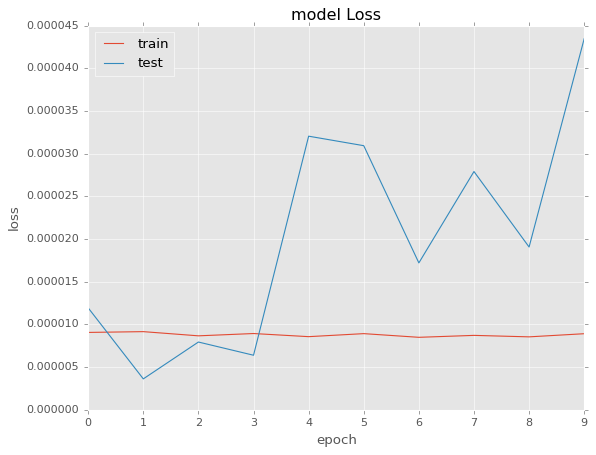

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label="train_accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
#plt.step(history.history['loss'], 10)
plt.title('model accuracy')
plt.ylabel('Train Accuracy')
plt.xlabel('epoch')
plt.legend(['train', "test"], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
save_mod(model,"/content/CSRNet-keras/weights/model_visdrone_weights.h5","/content/CSRNet-keras/models/Model.json")

In [ ]:
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 2.2.0 , GPU: /device:GPU:0



# Test on validation data

In [ ]:
from keras.models import model_from_json
import os
import cv2
import glob
import h5py
import pandas as pd
from sklearn.metrics import mean_absolute_error
import scipy.io as io
from PIL import Image
import numpy as np
import time

In [ ]:
def load_model():
    
    json_file = open('/content/Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/best_weights1.h5")
    return loaded_model


def create_img(path):
    im = Image.open(path).convert('RGB')
    im = np.array(im)
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im

In [ ]:
path_setss = [test]

In [ ]:
path_setss

['/content/test/sequences']

In [ ]:
img_pathss = []
for path in path_setss:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_pathss.append(img_path)
print(len(img_pathss))

210


nombre vrai de personnes  /  nombre de personnes estimé

In [ ]:
model = load_model()
name = []
y_true = []
y_pred = []
tim = []
for image in img_pathss:
    name.append(image)
    gt = h5py.File(image.replace('.jpg','.h5').replace('sequences','ground_truth') )
    groundtruth = np.asarray(gt['density'])
    num1 = np.sum(groundtruth)

    y_true.append(np.sum(num1))
    img = create_img(image)
    start_time = time.time()
    num = np.sum(model.predict(img))
    #print("--- %s seconds ---" % (time.time() - start_time))
    tim.append(float(time.time() - start_time))
    y_pred.append(num)
    print(num1, num)

print(sum(tim)/len(tim), max(tim), min(tim))
data = pd.DataFrame({'name': name,'y_pred': y_pred,'y_true': y_true, "temp-ex": tim})
data.to_csv('/content/CSRNet-keras/CSV/30train_30test.csv', sep=',')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


416.9999999999998 400.86765
409.0000000000003 403.08072
160.0000000000001 156.59248
169.00000000000006 170.37404
254.0000000000001 259.41168
310.99999999999994 311.57657
160.00000000000003 146.36252
233.99999999999994 230.54738
239.00000000000006 236.14607
366.0000000000002 362.8808
180.00000000000003 175.47624
225.00000000000006 248.40813
228.99999999999997 249.53772
168.00000000000009 161.69017
221.0000000000001 242.76093
170.00000000000003 168.99763
173.00000000000003 174.2635
230.99999999999994 237.51613
392.9999999999999 348.1172
393.00000000000006 348.81476
230.99999999999997 264.03888
182.99999999999991 169.36626
173.00000000000003 173.16742
183.99999999999994 183.40233
308.00000000000006 333.59628
373.0000000000001 386.51593
311.00000000000006 288.79355
363.0 336.02185
316.0 335.04816
313.0000000000001 321.07986
317.00000000000006 317.2129
413.0 399.00555
303.9999999999999 290.31335
254.99999999999997 258.03217
170.00000000000003 177.15692
170.00000000000006 171.24069
186.00000

In [ ]:
data = pd.read_csv('/content/CSRNet-keras/CSV/30train_30test.csv')
y_true = data['y_true']
y_pred = data['y_pred']

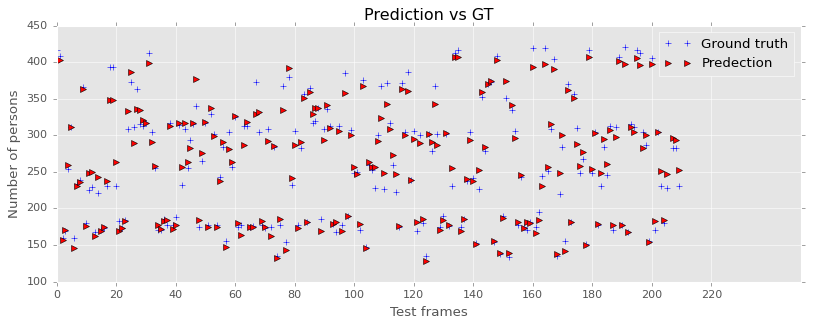

In [ ]:
N = len(img_pathss)
plt.style.use("ggplot")
plt.figure(figsize = (12,4))
plt.plot(y_true, 'b+', label = "Ground truth")
plt.plot(y_pred, 'r>', label = "Predection")


plt.title('Prediction vs GT')
plt.xlabel("Test frames")
plt.ylabel("Number of persons")
plt.xticks(np.arange(0,N+20,20))

plt.legend(loc="upper right")
plt.savefig("plotPredectionGT.png")

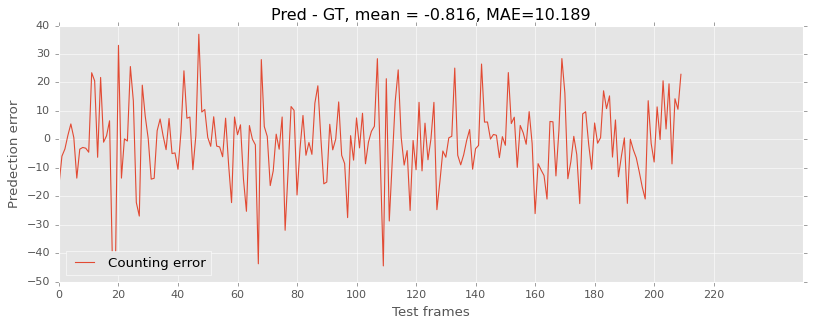

In [ ]:
N = len(img_pathss)
plt.style.use("ggplot")
plt.figure(figsize = (12,4))

error = np.array(y_pred) - np.array(y_true)
plt.plot(error, label = "Counting error")

plt.title('Pred - GT, mean = {}, MAE={}'.format(
    str(round(np.mean(error), 3)),
    str(round(np.mean(np.abs(error)), 3))
))
plt.xlabel("Test frames")
plt.ylabel("Predection error")
plt.xticks(np.arange(0,N+20,20))

plt.legend(loc="lower left")
plt.savefig("plotLoss.png")

In [ ]:
ans = mean_absolute_error(np.array(y_true),np.array(y_pred))

In [ ]:
print("MAE : " , ans )

MAE :  8.107724871816522


In [ ]:
#print(y_true,y_pred )
p = 0
for i in  y_true:
  print(int(i), int(y_pred[p]))
  p+=1

In [ ]:
def predict(path):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    model = load_model()
    image = create_img(path)
    start_time = time.time()
    ans = model.predict(image)
    print("--- %s seconds ---" % (time.time() - start_time))
    count = np.sum(ans)
    return count,image,ans

In [ ]:
import time, matplotlib

In [ ]:
matplotlib.pyplot.rcdefaults()

In [ ]:
img = create_img("/content/test/sequences/uav0000072_04488_v0000003.jpg")
start_time = time.time()
num = np.sum(model.predict(img))
print(float(time.time() - start_time))
print(num)

0.16068196296691895
105.808014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


354.21875


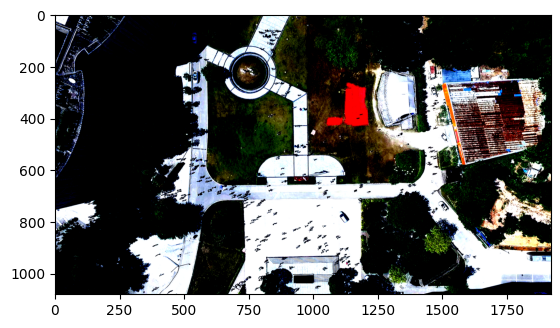

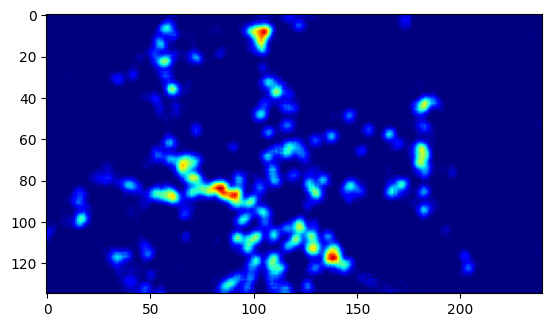

In [ ]:
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

model to h5

In [ ]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('/content/CSRNet-keras/models/Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/log/best_weights.h5")
    return loaded_model

In [ ]:
model = load_model()

In [ ]:
model.save("model_2020.h5")